In [1]:
import random
import struct
import subprocess

import galois
import numpy as np
from IPython.display import Image

In [2]:
GF = galois.GF(2**16)

# Packet format
#
# Systematic packet (backwards compatible with ssdv)
#
# u8        image ID
# u16       packet ID
# u8        width
# u8        height
# u8        flags
# u8        MCU offset (*)
# u16       MCU index (*)
# [u8; 205] payload data (*)
# u32       CRC
#
# (*) forms part of erasure FEC codeword
#
# Erasure FEC packet (cannot be processed by legacy ssdv)
#
# u8        image ID
# u16       packet ID
# u16       number of systematic packets (used to determine image size if EOI packet is missing)
# u8        flags (set bit 0x40 to indicate FEC packet)
# [u8; 208] erasure FEC data
# u32       CRC

# Erasure FEC is a fountain-like systematic RS-like (2^16, k) code over GF(2^16)

CRC32_DSLWP_MAGIC_VALUE = 0x4EE4FDE1

def crc32(data):
    crc = CRC32_DSLWP_MAGIC_VALUE
    for d in data:
        x = (crc ^ d) & 0xFF;
        for i in range(7, -1, -1):
            if x & 1:
                x = (x >> 1) ^ 0xEDB88320
            else:
                x >>= 1
        crc = (crc >> 8) ^ x
    return crc ^ 0xFFFFFFFF


class SSDVErasureFECEncoder:
    def __init__(self, ssdv_data):
        self.k = len(ssdv_data)
        self.n = 2**16
        header_len = 6
        crc_len = 4
        systdata = GF([np.frombuffer(d[header_len:-crc_len], 'uint8').view('uint16').byteswap()
                       for d in ssdv_data])
        V = GF([[GF(b)**a for a in range(self.k)] for b in range(self.k)])
        self.enc = np.linalg.solve(V, systdata).T
        header = ssdv_data[0][:header_len]
        self.image_id, _, self.width, self.height, self.flags = struct.unpack('>BHBBB', header)
    
    def generate_packet(self, num_packet):
        if num_packet >= self.n:
            raise ValueError('num_packet too large')
        data = self.enc @ GF([GF(num_packet)**a for a in range(self.k)])
        data = bytes(np.array(data).view('uint16').byteswap().view('uint8'))
        if num_packet < self.k:
            # systematic packet
            flags = self.flags | (0x4 if num_packet == self.k - 1 else 0)
            header = struct.pack('>BHBBB', self.image_id, num_packet, self.width, self.height,
                                 flags)
        else:
            # FEC packet
            flags = self.flags | 0x40  # flag marks FEC packet
            header = struct.pack('>BHHB', self.image_id, num_packet, self.k, flags)
        packet = header + data
        crc = struct.pack('>I', crc32(packet))
        return packet + crc

class SSDVErasureFECDecoder:
    def __init__(self):
        self.n = 2**16
        self.header_len = 6
    
    def decode(self, packets):
        # check CRCs
        crc_len = 4
        packets = [p for p in packets
                   if struct.unpack('>I', p[-crc_len:])[0] == crc32(p[:-crc_len])]
        # remove duplicates
        packets = list(set(packets))
        
        k = self.find_k(packets)
        if k is None:
            return
        
        header = self.find_syst_header(packets)
        if header is None:
            return
        image_id, _, width, height, flags = header
        flags &= ~0x4  # remove EOI flag if present
        
        data = GF([np.frombuffer(p[self.header_len:-crc_len], 'uint8').view('uint16').byteswap()
                   for p in packets])
        nums = [struct.unpack('>BH', p[:3])[1] for p in packets]
        if len(nums) != len(set(nums)):
            # There are packets with same number but different data
            return
        if len(nums) < k:
            # Not enough packets for decode
            return
        
        V = GF([[GF(b)**a for a in range(k)] for b in nums[:k]])
        enc = np.linalg.solve(V, data[:k]).T
        
        decoded = (enc @ GF([[GF(n)**a for n in range(k)]
                             for a in range(k)])).T
        decoded = [bytes(np.array(d).view('uint16').byteswap().view('uint8'))
                  for d in decoded]
        
        headers = [struct.pack('>BHBBB', image_id, n, width, height,
                               flags | (0x4 if n == k - 1 else 0))
                   for n in range(k)]
        packets = [h + d for h, d in zip(headers, decoded)]
        crcs = [struct.pack('>I', crc32(p)) for p in packets]
        return [p + c for p, c in zip(packets, crcs)]
        
    def find_k(self, packets):
        for p in packets:
            if p[self.header_len - 1] & 0x40:
                # FEC packet. Read k directly
                return struct.unpack('>BHHB', p[:self.header_len])[2]
            if p[self.header_len - 1] & 0x4:
                # EOI marker. Use num_packet
                num_packet = struct.unpack('>BHBBB', p[:self.header_len])[1]
                return num_packet + 1
    
    def find_syst_header(self, packets):
        for p in packets:
            if not p[self.header_len - 1] & 0x40:
                # FEC packet. Read k directly
                return struct.unpack('>BHBBB', p[:self.header_len])

In [3]:
SSDV_PATH = '/home/daniel/ssdv/ssdv'

## Image 230 from [DSLWP public data release v1.0](https://zenodo.org/record/3571330#.ZFlUiI1ByCg)

We use the SSDV packets for this image to test the erasure FEC algorithm. All the SSDV packets for this image were received on ground.

Load SSDV packets from file.

In [4]:
with open('img_230.ssdv', 'rb') as f:
    ssdv_data = f.read()

packet_len = 218
ssdv_data = [ssdv_data[j:][:packet_len] for j in range(0, len(ssdv_data), packet_len)]
# remove duplicate packets
ssdv_data = list(set(ssdv_data))
ssdv_data.sort()

Decode image with SSDV and show JPEG.

In [5]:
ssdv_data_path = '/tmp/ssdv_data'
ssdv_jpg_path = '/tmp/ssdv_data.jpg'
with open(ssdv_data_path, 'wb') as f:
    for d in ssdv_data:
        f.write(d)
subprocess.run([SSDV_PATH, '-D', '-d', ssdv_data_path, ssdv_jpg_path])

Callsign: DSLWP
Image ID: E6
Resolution: 640x480
MCU blocks: 2400
Sampling factor: 2x1
Quality level: 5
Read 65 packets


CompletedProcess(args=['/home/daniel/ssdv/ssdv', '-D', '-d', '/tmp/ssdv_data', '/tmp/ssdv_data.jpg'], returncode=0)

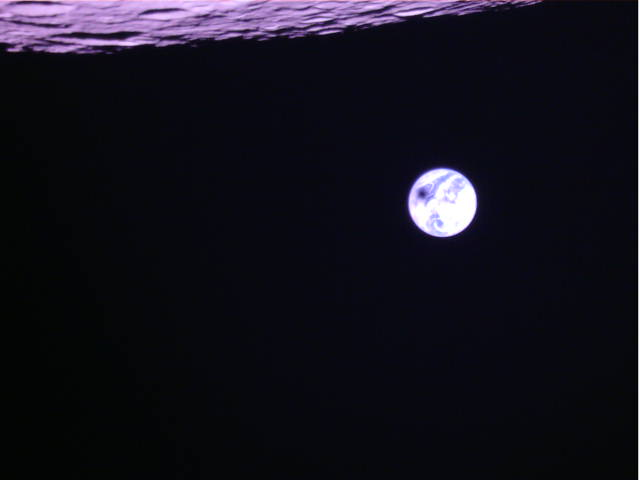

In [6]:
Image(ssdv_jpg_path)

## Erasure FEC encoding

Encode twice as many packets as there are in the original image. The maximum number of packets that can be produced is $2^{16}$, and new packets can be produced on the fly as required.

Check that the first packets produced are exactly the same as the original SSDV packets.

In [7]:
fec = SSDVErasureFECEncoder(ssdv_data)
ssdv_fec_data = [fec.generate_packet(n) for n in range(2 * len(ssdv_data))]
assert ssdv_fec_data[:len(ssdv_data)] == ssdv_data

## Reception with 50% packet loss

Simulate 50% packet loss. From the set of $2k$ packets, we chose randomly $k$ packets. Since SSDV only processes systematic packets, there are not enough packets to decode the image completely without erasure FEC decoding, but the partial image can be displayed, even as it is being received.

In [8]:
received_fec_data = sorted(random.sample(ssdv_fec_data, len(ssdv_data)))
received_fec_data_syst = [r for r in received_fec_data if r[5] & 0x40 == 0]
print(f'Received {len(received_fec_data_syst)} systematic SSDV packets')

with open(ssdv_data_path, 'wb') as f:
    for d in received_fec_data_syst:
        f.write(d)
subprocess.run([SSDV_PATH, '-D', '-d', ssdv_data_path, ssdv_jpg_path])

Received 29 systematic SSDV packets


Callsign: DSLWP
Image ID: E6
Resolution: 640x480
MCU blocks: 2400
Sampling factor: 2x1
Quality level: 5
Gap detected between packets -1 and 1
Gap detected between packets 2 and 5
Gap detected between packets 5 and 11
Gap detected between packets 11 and 13
Gap detected between packets 15 and 17
Gap detected between packets 18 and 21
Gap detected between packets 24 and 26
Gap detected between packets 26 and 29
Gap detected between packets 29 and 31
Gap detected between packets 31 and 36
Gap detected between packets 37 and 40
Gap detected between packets 40 and 42
Gap detected between packets 43 and 47
Gap detected between packets 48 and 54
Gap detected between packets 57 and 60
Read 29 packets


CompletedProcess(args=['/home/daniel/ssdv/ssdv', '-D', '-d', '/tmp/ssdv_data', '/tmp/ssdv_data.jpg'], returncode=0)

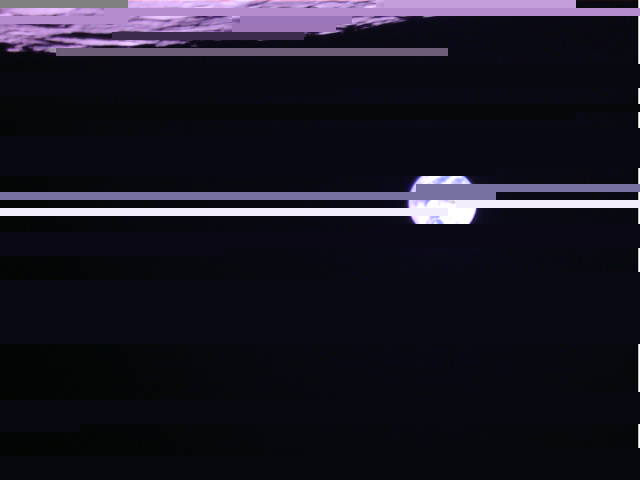

In [9]:
Image(ssdv_jpg_path)

Perform erasure FEC decoding to recover the whole image. This succeeds, because we have $k$ distinct packets in total.

In [10]:
decoder = SSDVErasureFECDecoder()
decoded_data = decoder.decode(received_fec_data)
assert decoded_data == ssdv_data

In [11]:
with open(ssdv_data_path, 'wb') as f:
    for d in decoded_data:
        f.write(d)
subprocess.run([SSDV_PATH, '-D', '-d', ssdv_data_path, ssdv_jpg_path])

Callsign: DSLWP
Image ID: E6
Resolution: 640x480
MCU blocks: 2400
Sampling factor: 2x1
Quality level: 5
Read 65 packets


CompletedProcess(args=['/home/daniel/ssdv/ssdv', '-D', '-d', '/tmp/ssdv_data', '/tmp/ssdv_data.jpg'], returncode=0)

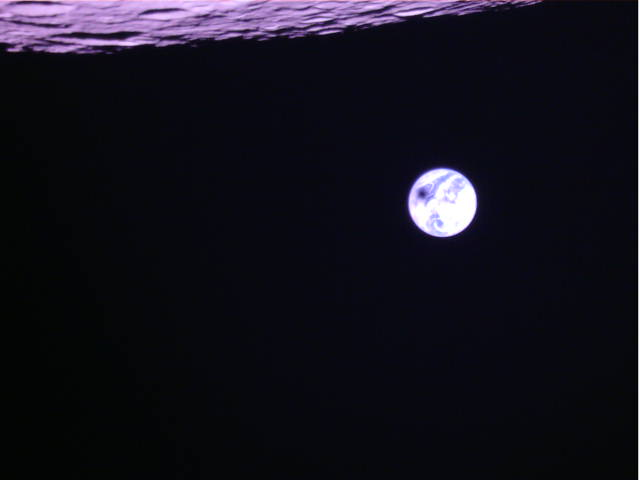

In [12]:
Image(ssdv_jpg_path)

## Insufficient packets for erasure decoding

Now we only choose $k - 1$ packets out of the set of $2k$ transmitted packets. This is not enough for erasure decoding, so only the partial image of systematic packets can be shown. More packets could be encoded and trasnmitted to increase the number of received packets to $k$.

In [13]:
received_fec_data = sorted(random.sample(ssdv_fec_data, len(ssdv_data) - 1))

received_fec_data_syst = [r for r in received_fec_data if r[5] & 0x40 == 0]
print(f'Received {len(received_fec_data_syst)} systematic SSDV packets')

with open(ssdv_data_path, 'wb') as f:
    for d in received_fec_data_syst:
        f.write(d)
subprocess.run([SSDV_PATH, '-D', '-d', ssdv_data_path, ssdv_jpg_path])

Received 34 systematic SSDV packets


Callsign: DSLWP
Image ID: E6
Resolution: 640x480
MCU blocks: 2400
Sampling factor: 2x1
Quality level: 5
Gap detected between packets 0 and 2
Gap detected between packets 3 and 5
Gap detected between packets 8 and 13
Gap detected between packets 13 and 17
Gap detected between packets 17 and 19
Gap detected between packets 20 and 22
Gap detected between packets 22 and 25
Gap detected between packets 28 and 32
Gap detected between packets 33 and 35
Gap detected between packets 36 and 38
Gap detected between packets 40 and 42
Gap detected between packets 42 and 44
Gap detected between packets 45 and 48
Gap detected between packets 48 and 52
Gap detected between packets 53 and 56
Gap detected between packets 56 and 59
Gap detected between packets 59 and 61
Gap detected between packets 61 and 63
Read 34 packets


CompletedProcess(args=['/home/daniel/ssdv/ssdv', '-D', '-d', '/tmp/ssdv_data', '/tmp/ssdv_data.jpg'], returncode=0)

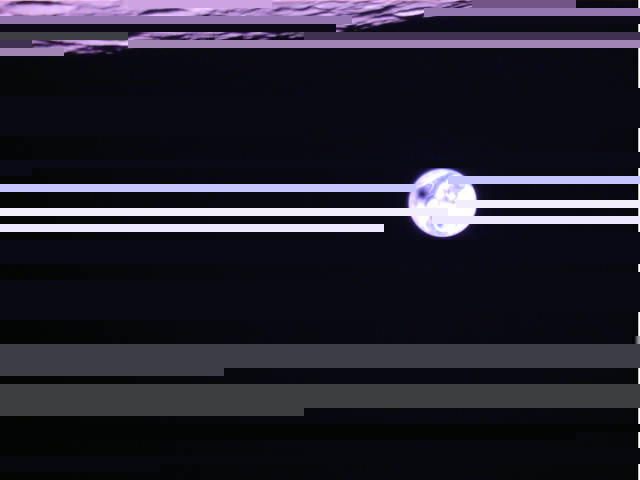

In [14]:
Image(ssdv_jpg_path)

In [15]:
decoded_data = decoder.decode(received_fec_data)
assert decoded_data is None

## Reception with 25% packet loss

This simulates a reception with 25% packet loss. From the original set of $2k$ packets we get $3k/2$, which is more than we need for erasure decoding, so erasure decoding is successful.

In [16]:
received_fec_data = sorted(random.sample(ssdv_fec_data, round(1.5 * len(ssdv_data))))
received_fec_data_syst = [r for r in received_fec_data if r[5] & 0x40 == 0]
print(f'Received {len(received_fec_data_syst)} systematic SSDV packets')

with open(ssdv_data_path, 'wb') as f:
    for d in received_fec_data_syst:
        f.write(d)
subprocess.run([SSDV_PATH, '-D', '-d', ssdv_data_path, ssdv_jpg_path])

Received 52 systematic SSDV packets


Callsign: DSLWP
Image ID: E6
Resolution: 640x480
MCU blocks: 2400
Sampling factor: 2x1
Quality level: 5
Gap detected between packets 2 and 6
Gap detected between packets 11 and 13
Gap detected between packets 13 and 15
Gap detected between packets 15 and 17
Gap detected between packets 18 and 20
Gap detected between packets 20 and 22
Gap detected between packets 22 and 25
Gap detected between packets 28 and 30
Gap detected between packets 57 and 59
Gap detected between packets 59 and 61
Read 52 packets


CompletedProcess(args=['/home/daniel/ssdv/ssdv', '-D', '-d', '/tmp/ssdv_data', '/tmp/ssdv_data.jpg'], returncode=0)

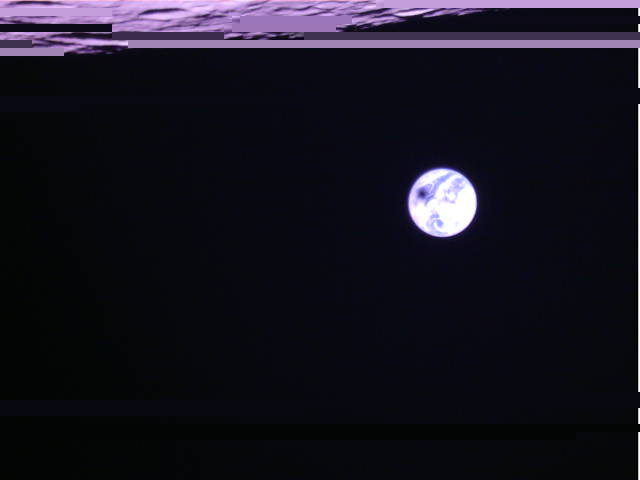

In [17]:
Image(ssdv_jpg_path)

In [18]:
decoded_data = decoder.decode(received_fec_data)
assert decoded_data == ssdv_data

In [19]:
with open(ssdv_data_path, 'wb') as f:
    for d in decoded_data:
        f.write(d)
subprocess.run([SSDV_PATH, '-D', '-d', ssdv_data_path, ssdv_jpg_path])

Callsign: DSLWP
Image ID: E6
Resolution: 640x480
MCU blocks: 2400
Sampling factor: 2x1
Quality level: 5
Read 65 packets


CompletedProcess(args=['/home/daniel/ssdv/ssdv', '-D', '-d', '/tmp/ssdv_data', '/tmp/ssdv_data.jpg'], returncode=0)

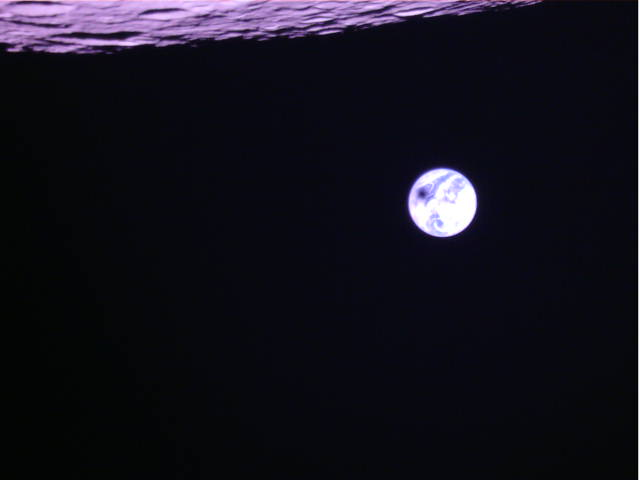

In [20]:
Image(ssdv_jpg_path)